## Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - 1) выделить целевые группы клиентов;
    - 2) предложить меры по снижению оттока;
    - 3) определить другие особенности взаимодействия с клиентами.

### Оглавление<a class="anchor" id="contents"></a>

* [Шаг 1. Загрузим данные](#chapter1)
* [Шаг 2. Проведём исследовательский анализ данных (EDA)](#chapter2)
* [Шаг 3. Построим модель прогнозирования оттока клиентов](#chapter3)
* [Шаг 4. Сделаем кластеризацию клиентов](#chapter4)
* [Шаг 5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами](#chapter5)
* [Выводы](#chapterend)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math
import datetime
from IPython.display import display
from plotly import graph_objects as go
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

## Шаг 1. Загрузим данные<a class="anchor" id="chapter1"></a>

In [2]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [4]:
gym_churn.duplicated().sum()

0

Дататасет состоит из 14 столбцов и 4000 строк. Названия столбцов одностилевые, не стану их заменять. Дубликаты отсутствуют.

Дататасет включает следующие поля:

- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- `Group_visits` — факт посещения групповых занятий;
- `Age` — возраст;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон;
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Churn` — факт оттока в текущем месяце.

### [К оглавлению](#contents)

## Шаг 2. Проведём исследовательский анализ данных (EDA)<a class="anchor" id="chapter2"></a>

In [5]:
gym_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**Выводы о среднестатистическом клиенте:**

- может быть как мужчиной, так и женщиной;
- чаще всего проживает или работает в районе фитнес-центра;
- почти в половине случаев сотрудник компании-партнёра клуба;
- в 30% случаев записался по акции «приведи друга»;
- почти всегда есть контактный телефон;
- его абонемент от трёх месяцев до полугода;
- в 41% случаев посещает групповые занятия;
- ему около 29 лет;
- пользуется другими услугами фитнес-центра незначительно;
- до конца его абонемента от трёх месяцев до полугода;
- посещает фитнес-центр уже четыре месяца;
- посещает фитнес-центр меньше двух раз в неделю;
- последний месяц стал ходить немного реже.

Выделим в отдельные группы тех, кто остался, — `gym_churn_stayed`, и тех, кто ушёл, — `gym_churn_gone`, убрав факт оттока в текущем месяце методом `drop`.

In [6]:
gym_churn_stayed = gym_churn[gym_churn['Churn'] == 0].drop(columns = ['Churn'])
gym_churn_stayed.shape

(2939, 13)

In [7]:
gym_churn_gone = gym_churn[gym_churn['Churn'] == 1].drop(columns = ['Churn'])
gym_churn_gone.shape

(1061, 13)

Заменим заголовки на более читаемые для обеих групп.

In [8]:
gym_churn_stayed.columns = ['Пол', \
                            'Проживание или работа в районе, где находится фитнес-центр', \
                            'Сотрудник компании-партнёра клуба', \
                            'Факт первоначальной записи в рамках акции «приведи друга»', \
                            'Наличие контактного телефона', \
                            'Длительность текущего действующего абонемента', \
                            'Факт посещения групповых занятий', \
                            'Возраст', \
                            'Суммарная выручка от других услуг фитнес-центра', \
                            'Срок до окончания текущего действующего абонемента', \
                            'Время с момента первого обращения в фитнес-центр', \
                            'Средняя частота посещений в неделю за все время с начала действия абонемента', \
                            'Средняя частота посещений в неделю за предыдущий месяц']

In [9]:
gym_churn_gone.columns = gym_churn_stayed.columns

В цикле по каждому признаку построим попарные гистограммы статистических параметров признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток). Для этого на каждой итерации создаём датафрейм из словаря с двумя ключами — `Остались`, `Ушли` — и значениями статистических параметров из метода `describe()` (кроме количества).

<Figure size 864x504 with 0 Axes>

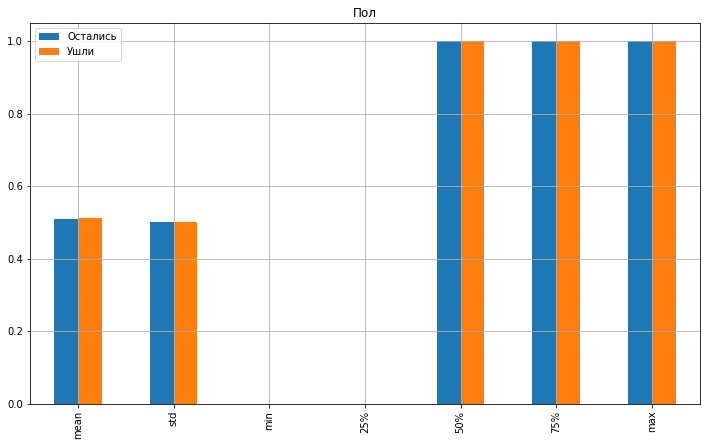

<Figure size 864x504 with 0 Axes>

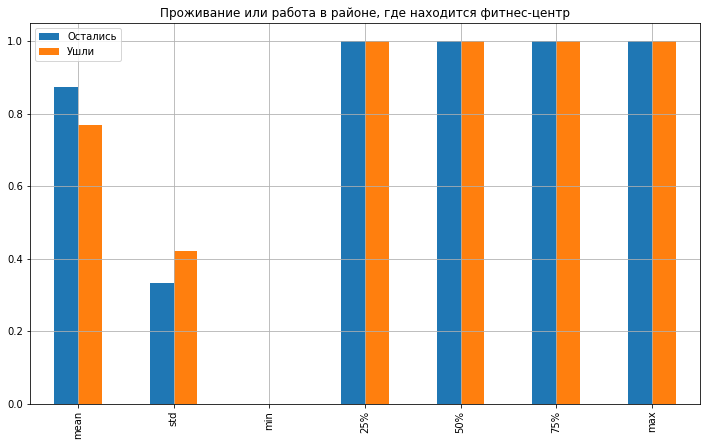

<Figure size 864x504 with 0 Axes>

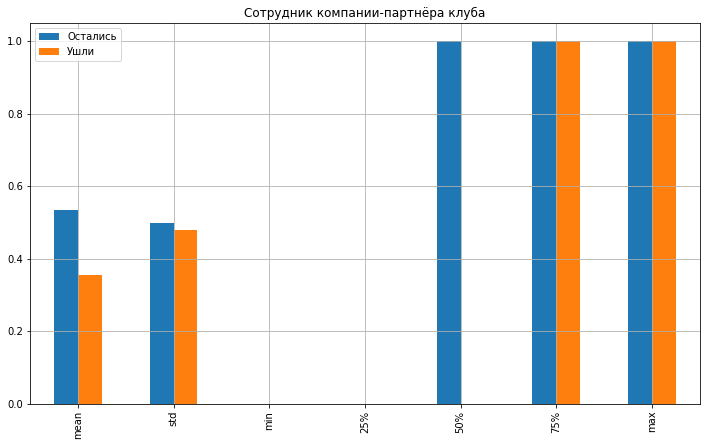

<Figure size 864x504 with 0 Axes>

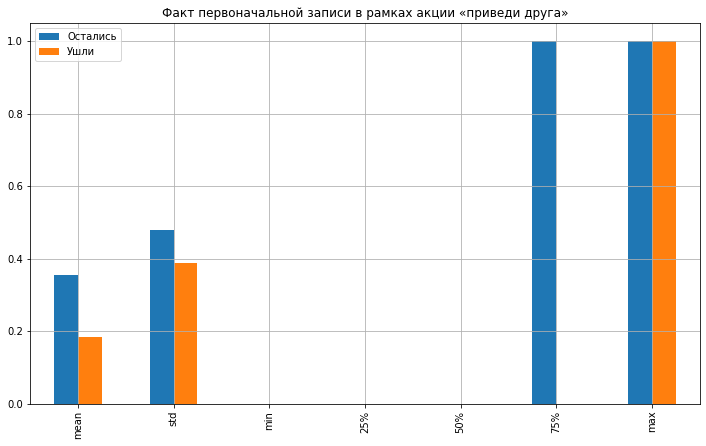

<Figure size 864x504 with 0 Axes>

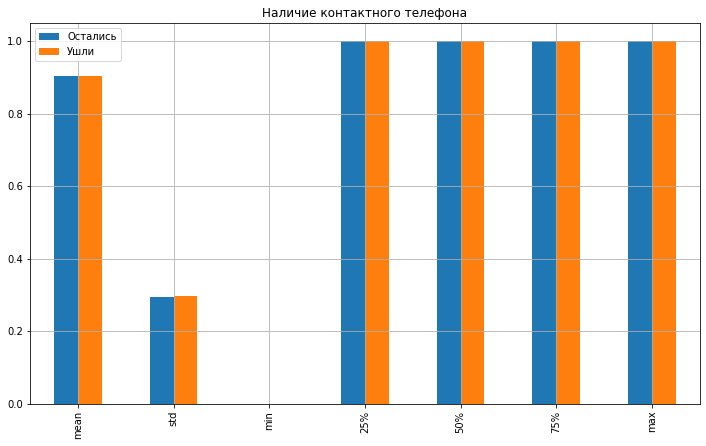

<Figure size 864x504 with 0 Axes>

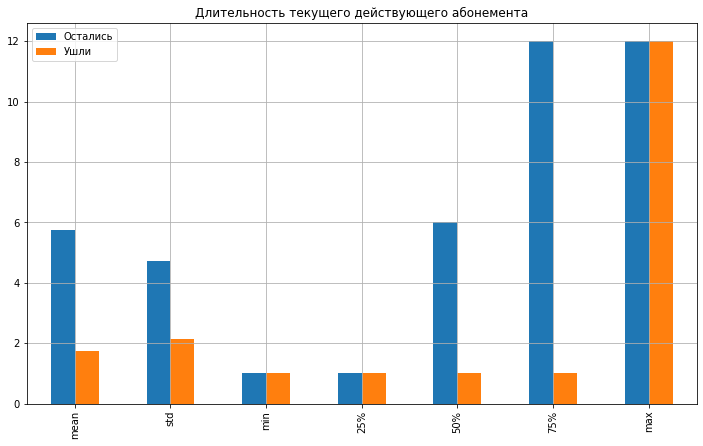

<Figure size 864x504 with 0 Axes>

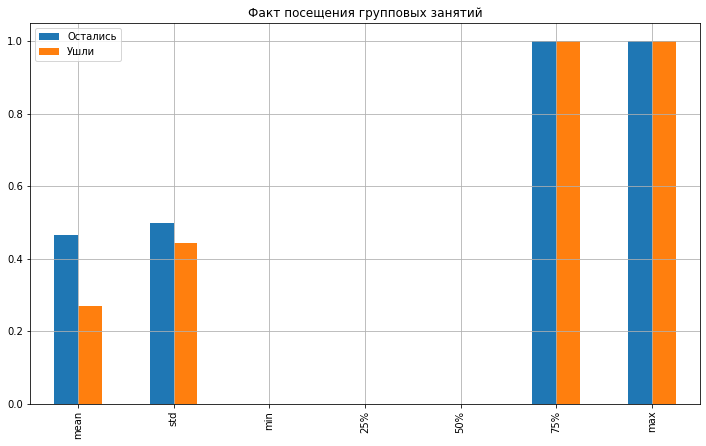

<Figure size 864x504 with 0 Axes>

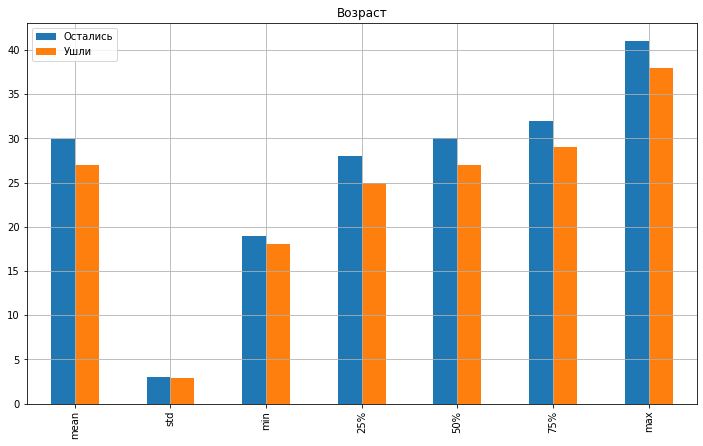

<Figure size 864x504 with 0 Axes>

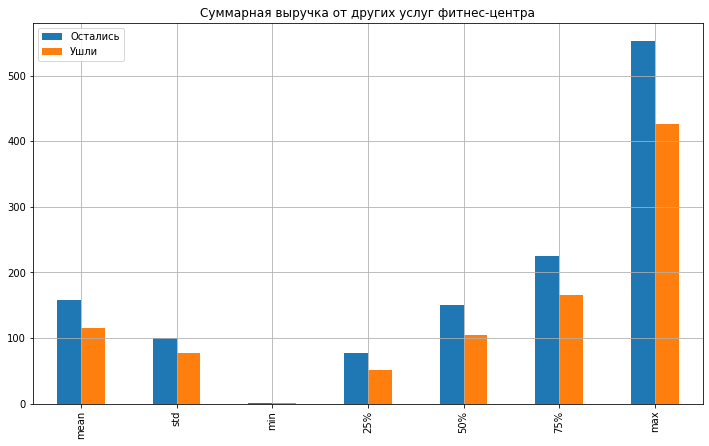

<Figure size 864x504 with 0 Axes>

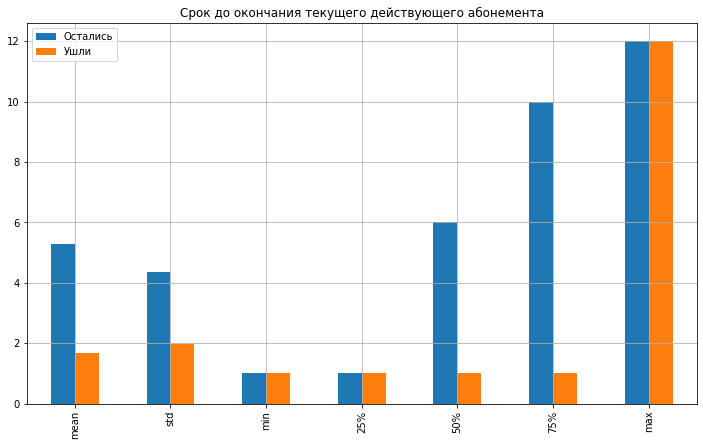

<Figure size 864x504 with 0 Axes>

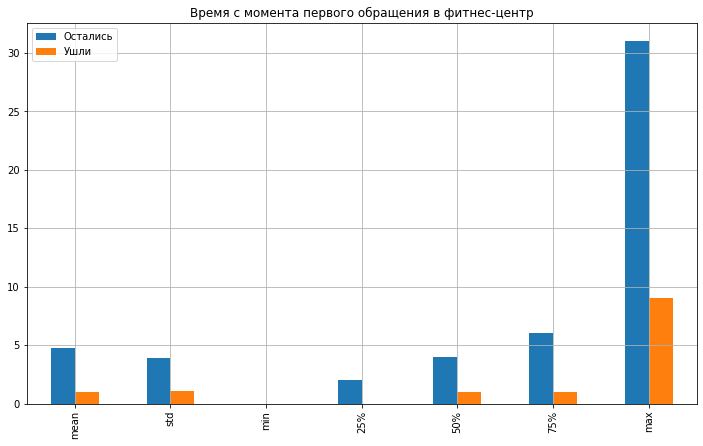

<Figure size 864x504 with 0 Axes>

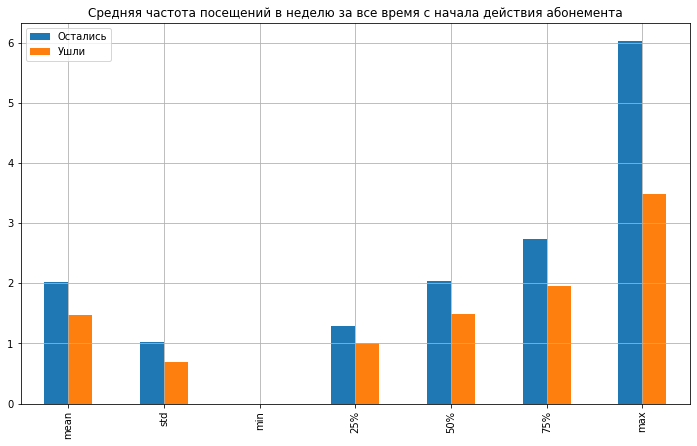

<Figure size 864x504 with 0 Axes>

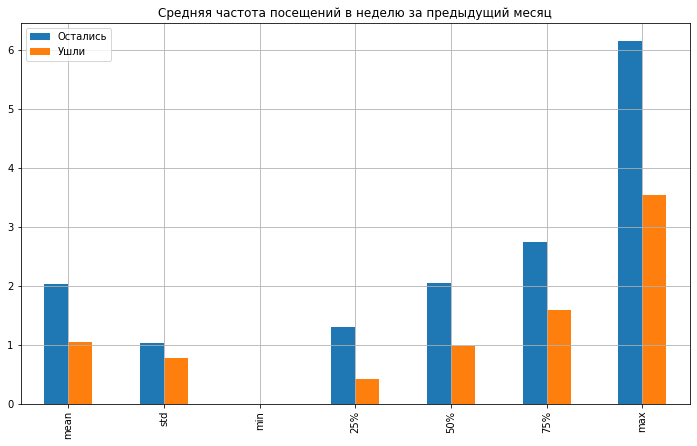

In [10]:
for i in gym_churn_stayed.columns:
    plt.figure(figsize=(12, 7))
    pd.DataFrame({'Остались':gym_churn_stayed[i].describe()[1:], \
                  'Ушли':gym_churn_gone[i].describe()[1:]}).plot(kind='bar', figsize=(12, 7), grid=True, title=i);

**Выводы:**

- пол мало влияет на отток;
- те, кто остался, чаще проживают или работают в районе, где находится фитнес-центр;
- сотрудники компаний-партнёров клуба чаще остаются;
- те, кто приходят от друзей, чаще остаются;
- наличие контактного телефона не влияет на отток;
- чем дольше длительность текущего действующего абонемента, тем выше вероятность остаться;
- посетители групповых занятий чаще остаются;
- посетители постарше чаще остаются;
- те, кто остался, чаще пользуются другими услугами фитнес-центра;
- чем дольше до окончания текущего действующего абонемента, тем чаще остаются;
- те, кто раньше обратились в фитнес-центр, чаще остаются;
- те, кто чаще посещают фитнес-центр (за всё время или за предыдущий месяц), чаще остаются.

Подвердим выводы, построив распределения для всех небинарных признаков.

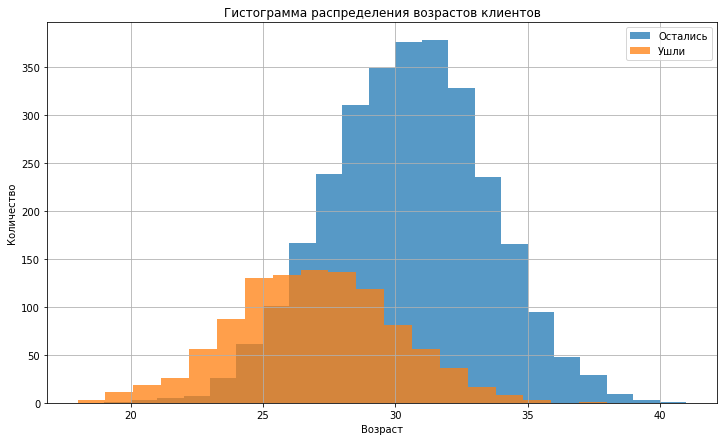

In [11]:
plt.figure(figsize=(12, 12))
gym_churn_stayed['Возраст'].hist(bins=len(gym_churn_stayed['Возраст'].unique()), \
                                 figsize=(12, 7), alpha=0.75, label='Остались')
gym_churn_gone['Возраст'].hist(bins=len(gym_churn_gone['Возраст'].unique()), \
                               figsize=(12, 7), alpha=0.75, label='Ушли')
plt.legend()
ax = plt.gca()
plt.grid(True)
ax.set_xlabel('Возраст')
ax.set_ylabel('Количество')
plt.title('Гистограмма распределения возрастов клиентов');

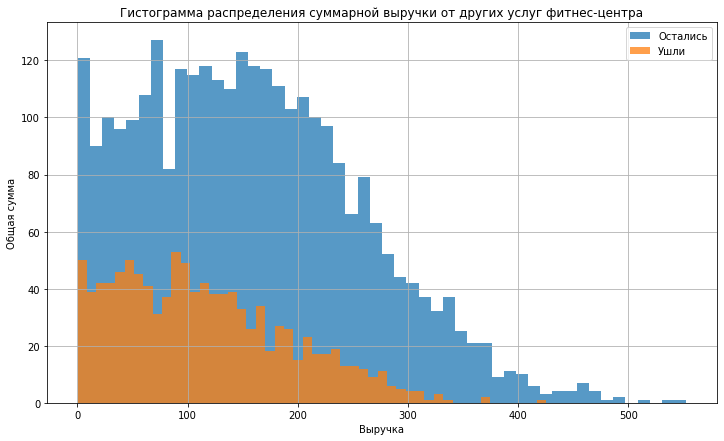

In [12]:
plt.figure(figsize=(12, 12))
gym_churn_stayed['Суммарная выручка от других услуг фитнес-центра'].hist(bins=50, \
                                                                         figsize=(12, 7), alpha=0.75, label='Остались')
gym_churn_gone['Суммарная выручка от других услуг фитнес-центра'].hist(bins=50, \
                                                                       figsize=(12, 7), alpha=0.75, label='Ушли')
plt.legend()
ax = plt.gca()
plt.grid(True)
ax.set_xlabel('Выручка')
ax.set_ylabel('Общая сумма')
plt.title('Гистограмма распределения cуммарной выручки от других услуг фитнес-центра');

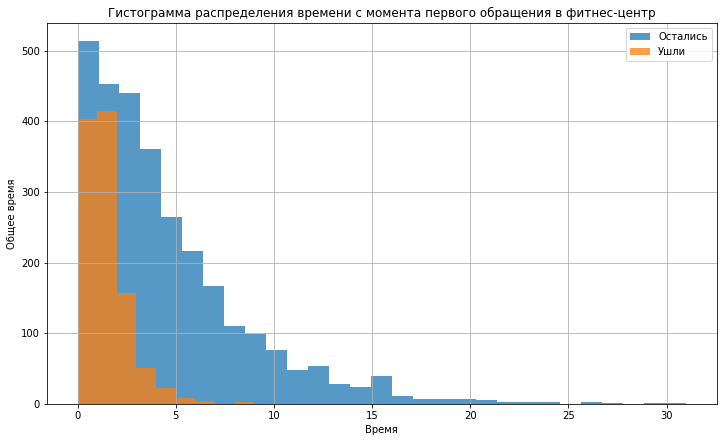

In [13]:
plt.figure(figsize=(12, 12))
gym_churn_stayed['Время с момента первого обращения в фитнес-центр'].\
hist(bins=len(gym_churn_stayed['Время с момента первого обращения в фитнес-центр'].unique()), \
     figsize=(12, 7), alpha=0.75, label='Остались')
gym_churn_gone['Время с момента первого обращения в фитнес-центр'].\
hist(bins=len(gym_churn_gone['Время с момента первого обращения в фитнес-центр'].unique()), \
     figsize=(12, 7), alpha=0.75, label='Ушли')
plt.legend()
ax = plt.gca()
plt.grid(True)
ax.set_xlabel('Время')
ax.set_ylabel('Общее время')
plt.title('Гистограмма распределения времени с момента первого обращения в фитнес-центр');

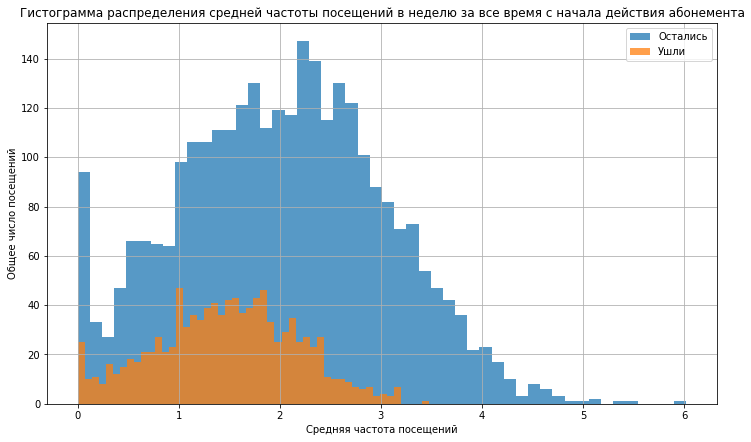

In [14]:
plt.figure(figsize=(12, 12))
gym_churn_stayed['Средняя частота посещений в неделю за все время с начала действия абонемента'].hist(bins=50, \
                                                                            figsize=(12, 7), alpha=0.75, label='Остались')
gym_churn_gone['Средняя частота посещений в неделю за все время с начала действия абонемента'].hist(bins=50, \
                                                                            figsize=(12, 7), alpha=0.75, label='Ушли')
plt.legend()
ax = plt.gca()
plt.grid(True)
ax.set_xlabel('Средняя частота посещений')
ax.set_ylabel('Общее число посещений')
plt.title('Гистограмма распределения средней частоты посещений в неделю за все время с начала действия абонемента');

Построим матрицу корреляций и отобразим её при помощи тепловой карты.

In [15]:
gym_churn_corr = gym_churn.drop(columns = ['Churn']).corr()

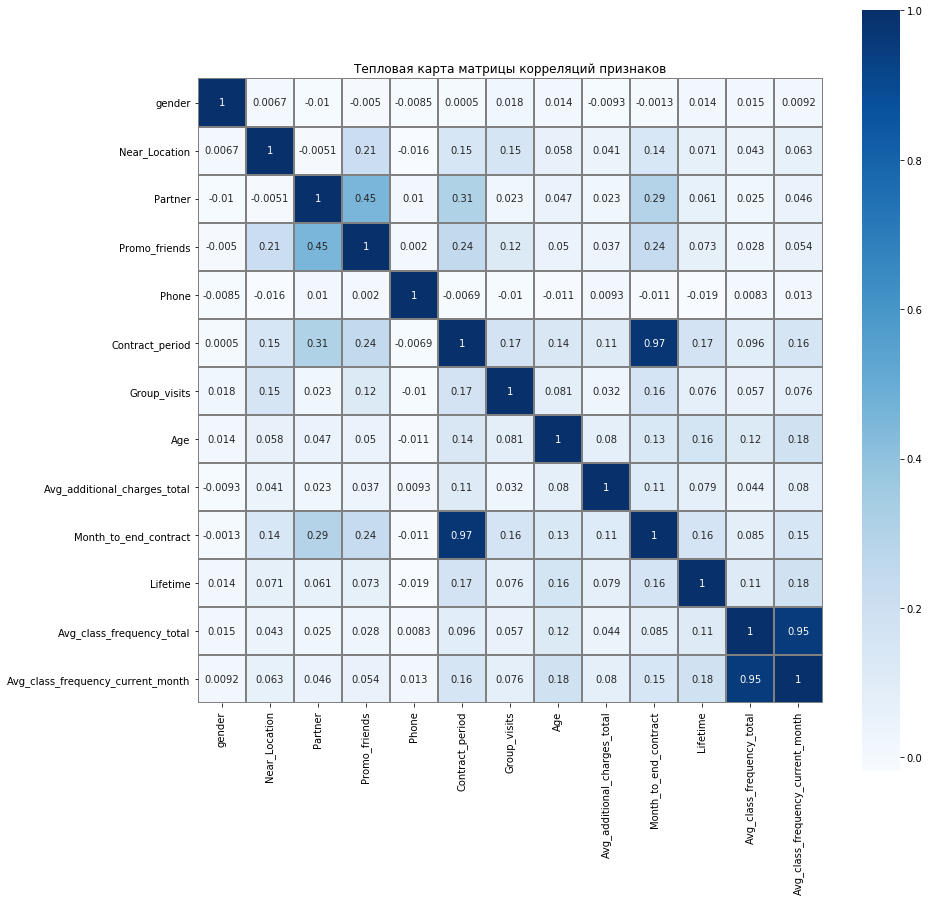

In [16]:
plt.figure(figsize = (14,14))
plt.title('Тепловая карта матрицы корреляций признаков')
sns.heatmap(gym_churn_corr, cmap='Blues', linewidths=1, linecolor='gray', square = True, annot = True);

**Вывод:** следующие признаки сильно коррелируют: `Contract_period` — длительность текущего действующего абонемента и `Month_to_end_contract` — срок до окончания текущего действующего абонемента, `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента и `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц.

### [К оглавлению](#contents)

## Шаг 3. Построим модель прогнозирования оттока клиентов<a class="anchor" id="chapter3"></a>

Разделим наши данные на признаки (матрица X) и целевую переменную (y). Не будем включать в матрицу X по одному в каждой паре коррелирующих признаков — `Month_to_end_contract` и `Avg_class_frequency_current_month`.

In [17]:
X = gym_churn.drop(columns = ['Churn', 'Month_to_end_contract', 'Avg_class_frequency_current_month'])

In [18]:
y = gym_churn['Churn']

Разделим данные на обучающую и валидационную выборку функцией `train_test_split()`.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)

Создадим объект класса `StandardScaler` и применим его к обучающей выборке.

In [20]:
scaler = StandardScaler()

Обучаем `scaler` и одновременно трансформируем матрицу для обучающей выборки.

In [21]:
X_train_st = scaler.fit_transform(X_train)

Применяем стандартизацию к матрице признаков для тестовой выборки.

In [22]:
X_test_st = scaler.transform(X_test)

1. Обучим модель на train-выборке при помощи логистической регрессии.

In [23]:
model = LogisticRegression(random_state = 42)

Обучим модель.

In [24]:
model.fit(X_train_st, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Сделаем прогноз.

In [25]:
LR_prediction = model.predict(X_test_st)

Оценим метрики *accuracy*, *precision* и *recall*.

In [26]:
LR_accuracy = accuracy_score(y_test, LR_prediction)
LR_precision = precision_score(y_test, LR_prediction)
LR_recall = recall_score(y_test, LR_prediction)

Сохраним коэффициенты линейной регрессии.

In [27]:
feature_weights = pd.DataFrame(model.coef_)

2. Обучим модель на train-выборке при помощи случайного леса.

In [28]:
model = RandomForestClassifier(random_state = 42)

Обучим модель.

In [29]:
model.fit(X_train_st, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Сделаем прогноз.

In [30]:
RF_prediction = model.predict(X_test_st)

Оценим метрики *accuracy*, *precision* и *recall*.

In [31]:
RF_accuracy = accuracy_score(y_test, RF_prediction)
RF_precision = precision_score(y_test, RF_prediction)
RF_recall = recall_score(y_test, RF_prediction)

Сравним метрики обеих моделей. Создадим датафрейм из словаря с двумя ключами — `LogisticRegression`, `RandomForest` — и значениями найденных метрик. В качестве индексов выступают названия метрик.

In [32]:
LR_RF_comparison = pd.DataFrame({'LogisticRegression':[LR_accuracy, LR_precision, LR_recall], \
                                 'RandomForest':[RF_accuracy, RF_precision, RF_recall]}, \
                                index=['Accuracy', 'Precision', 'Recall'])

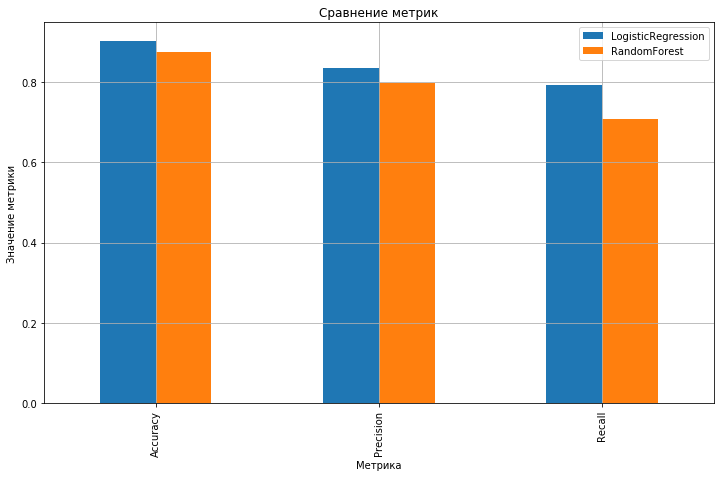

In [33]:
LR_RF_comparison.plot(kind='bar', figsize=(12, 7), grid=True, title='Сравнение метрик')
ax = plt.gca()
ax.set_ylabel('Значение метрики')
ax.set_xlabel('Метрика');

**Вывод:** модель логистической регрессии на данной выборке незначительно лучше модели случайного леса.

(*Почему?*)

Проведём анализ важности признаков в модели логистической регрессии. Заменим заголовки в матрице признаков.

In [34]:
feature_weights.columns = ['Пол', \
                           'Проживание или работа в районе, где находится фитнес-центр', \
                           'Сотрудник компании-партнёра клуба', \
                           'Факт первоначальной записи в рамках акции «приведи друга»', \
                           'Наличие контактного телефона', \
                           'Длительность текущего действующего абонемента', \
                           'Факт посещения групповых занятий', \
                           'Возраст', \
                           'Суммарная выручка от других услуг фитнес-центра', \
                           'Время с момента первого обращения в фитнес-центр', \
                           'Средняя частота посещений в неделю за все время с начала действия абонемента']

Транспонируем датафрейм, возьмём модули коэффициентов, сбросим индексы методом `reset_index()` и отсортируем по убыванию.

In [35]:
feature_weights = feature_weights.T.abs().reset_index().sort_values(by=0, ascending=False)

Визуализируем.

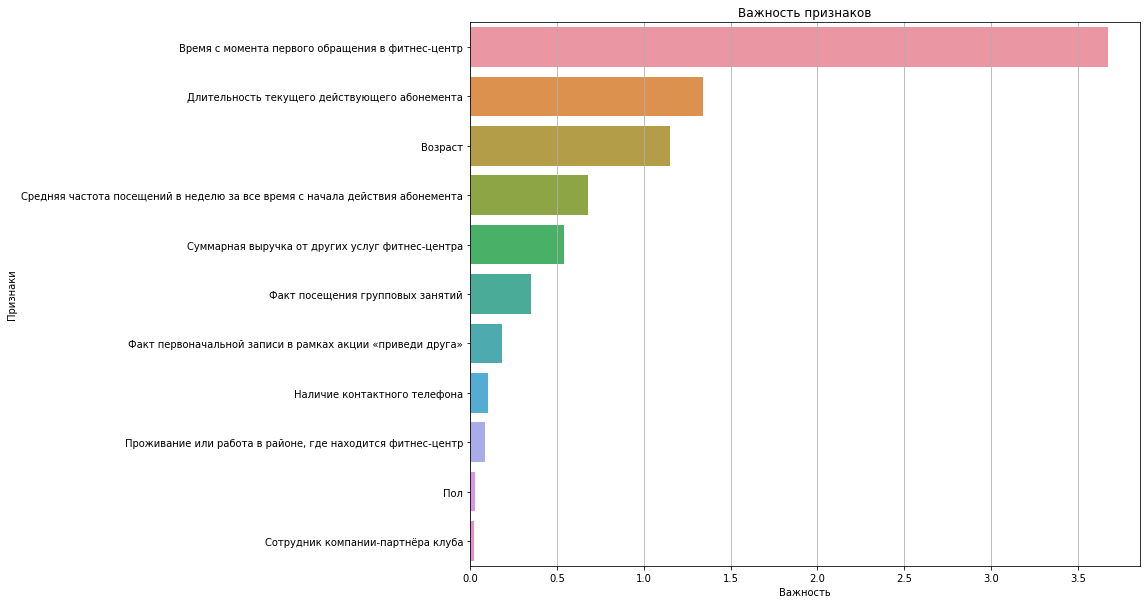

In [36]:
plt.figure(figsize=(12, 10))
plt.grid(True)
plt.title('Важность признаков')
sns.barplot(x=0, y="index", data=feature_weights, orient='h')
ax = plt.gca()
ax.set_ylabel('Признаки')
ax.set_xlabel('Важность');

**Вывод:** наиболее важными признаками оказались: время с момента первого обращения в фитнес-центр, длительность текущего действующего абонемента, возраст, средняя частота посещений в неделю и суммарная выручка от других услуг фитнес-центра.

### [К оглавлению](#contents)

## Шаг 4. Сделаем кластеризацию клиентов<a class="anchor" id="chapter4"></a>

Стандартизируем данные на случайной подвыборке из 500 элементов.

In [37]:
sc = StandardScaler()
X_sc = sc.fit_transform(X.sample(500))

Построим матрицу расстояний функцией `linkage()` со значением параметра `method = 'ward'` на стандартизованной матрице признаков.

In [38]:
linked = linkage(X_sc, method = 'ward')

Нарисуем дендрограмму.

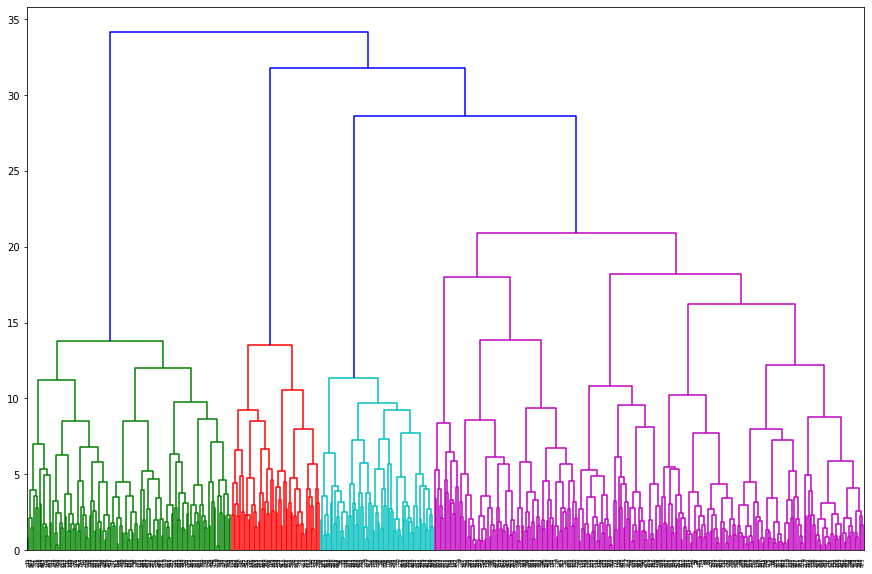

In [39]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Предложенное оптимальное число кластеров 5 — пять разных цветов на графике.

Обучим модель кластеризации на основании алгоритма K-Means с числом кластеров `n=5` и спрогнозируем кластеры клиентов.

In [40]:
km = KMeans(n_clusters = 5, random_state = 42)

Применяем алгоритм к данным и формируем вектор кластеров.

In [41]:
X_sc = sc.fit_transform(X)
labels = km.fit_predict(X_sc)

Добавим поле `Сluster` к датасету.

In [42]:
gym_churn['Сluster'] = labels

Для каждого полученного кластера посчитаем долю оттока (методом `groupby()`) и сохраним в переменную `cluster_churn_rate`.

In [43]:
cluster_churn_rate = gym_churn.groupby('Сluster').agg({'Churn': 'sum'})/gym_churn.groupby('Сluster').agg({'Churn': 'count'})

Отсортируем по возрастанию оттока.

In [44]:
cluster_churn_rate = cluster_churn_rate.sort_values(by='Churn', ascending=True).reset_index()
cluster_churn_rate

,Сluster,Churn
0,1,0.113059
1,2,0.220945
2,3,0.266839
3,0,0.382640
4,4,0.399287


Присвоим цвета: красный — кластерам с большим оттоком, зелёный — кластерам с маленьким оттоком.

In [45]:
cluster_churn_rate['Color'] = ["green", "limegreen", "yellow", "orangered", "red"]
cluster_churn_rate

,Сluster,Churn,Color
0,1,0.113059,green
1,2,0.220945,limegreen
2,3,0.266839,yellow
3,0,0.382640,orangered
4,4,0.399287,red


Вернём сортировку по кластерам.

In [46]:
cluster_churn_rate = cluster_churn_rate.sort_values(by='Сluster', ascending=True)
cluster_churn_rate

,Сluster,Churn,Color
3,0,0.382640,orangered
0,1,0.113059,green
1,2,0.220945,limegreen
2,3,0.266839,yellow
4,4,0.399287,red


Создадим переменную `gym_churn_clusters` со средними значениями признаков при помощи метода `groupby()`.

In [47]:
gym_churn_clusters = gym_churn.groupby('Сluster').agg({'gender': 'mean', \
                                                       'Near_Location': 'mean', \
                                                       'Partner': 'mean', \
                                                       'Promo_friends': 'mean', \
                                                       'Phone': 'mean', \
                                                       'Contract_period': 'mean', \
                                                       'Group_visits': 'mean', \
                                                       'Age': 'mean', \
                                                       'Avg_additional_charges_total': 'mean', \
                                                       'Month_to_end_contract': 'mean', \
                                                       'Lifetime': 'mean', \
                                                       'Avg_class_frequency_total': 'mean', \
                                                       'Avg_class_frequency_current_month': 'mean'})

In [48]:
gym_churn_clusters

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Сluster,,,,,,,,,,,,,
0,0.503986,1.000000,0.234721,0.062002,1,2.795394,0.000000,28.761736,143.366166,2.628875,3.311780,1.798457,1.643710
1,0.496056,0.995618,0.960561,0.818580,1,8.007011,0.498685,29.606486,154.944436,7.260298,4.361963,1.974414,1.931612
2,0.541507,1.000000,0.166028,0.088123,1,3.688378,1.000000,29.453384,148.529509,3.466156,3.761175,1.946217,1.841284
3,0.523316,0.862694,0.471503,0.305699,0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967
4,0.499109,0.000000,0.488414,0.076649,1,3.032086,0.235294,28.721925,137.540009,2.853832,3.060606,1.770413,1.606619


Найдём относительные значения.

In [49]:
gym_churn_clusters_2 = gym_churn_clusters / gym_churn_clusters.sum()
gym_churn_clusters_2

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Сluster,,,,,,,,,,,,,
0,0.196564,0.259181,0.101119,0.045891,0.25,0.125354,0.000000,0.197212,0.196773,0.127149,0.179637,0.192478,0.187913
1,0.193472,0.258045,0.413816,0.605883,0.25,0.359058,0.230719,0.203005,0.212664,0.351155,0.236601,0.211309,0.220827
2,0.211198,0.259181,0.071526,0.065225,0.25,0.165398,0.462654,0.201955,0.203859,0.167646,0.204013,0.208292,0.210500
3,0.204104,0.223594,0.203127,0.226268,0.00,0.214224,0.197767,0.200889,0.197928,0.216020,0.213735,0.198445,0.197088
4,0.194662,0.000000,0.210412,0.056733,0.25,0.135968,0.108860,0.196939,0.188776,0.138030,0.166013,0.189476,0.183673


Построим *stacked bar plot* с относительными средними значениями признаков.

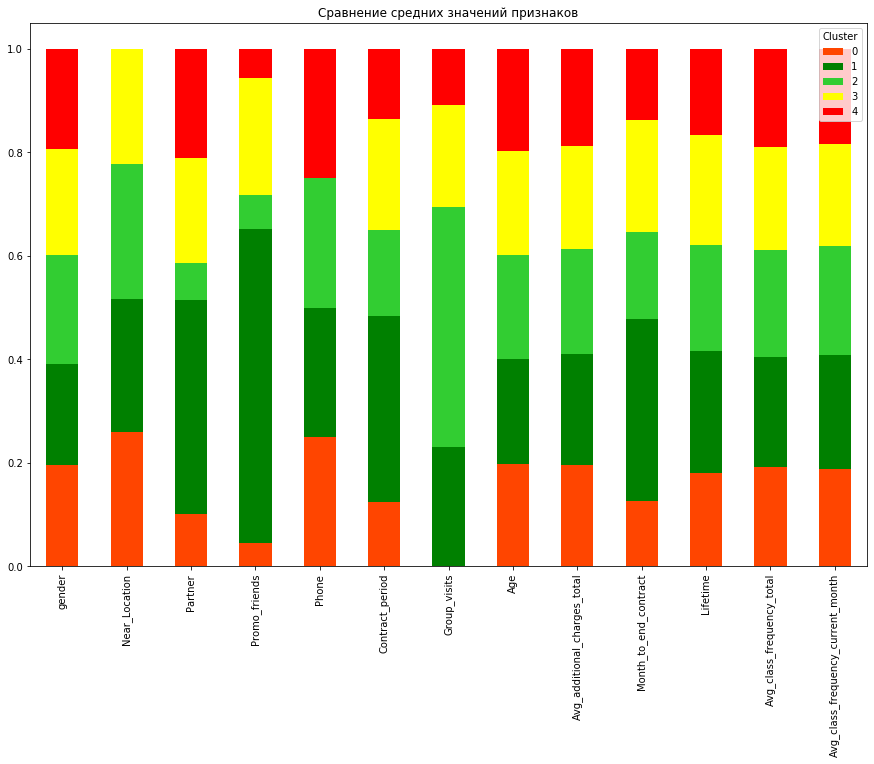

In [50]:
gym_churn_clusters_2.T.plot(kind="bar", \
                            stacked=True, \
                            figsize=(15, 10), \
                            color=cluster_churn_rate['Color'], \
                            title='Сравнение средних значений признаков');

**Выводы:** важность признаков, найденных алгоритмом *К средних*, отличается от модели логистической регрессии. Для *К средних* менее важны возраст, средняя частота посещений в неделю и суммарная выручка от других услуг фитнес-центра, зато он кластеризует по сотрудникам компаний-партнёров, акции «приведи друга», длительности действующего абонемента, посещению групповых занятий и времени с момента первого обращения в фитнес-центр.

Построим распределения небинарных признаков для кластеров.

No handles with labels found to put in legend.


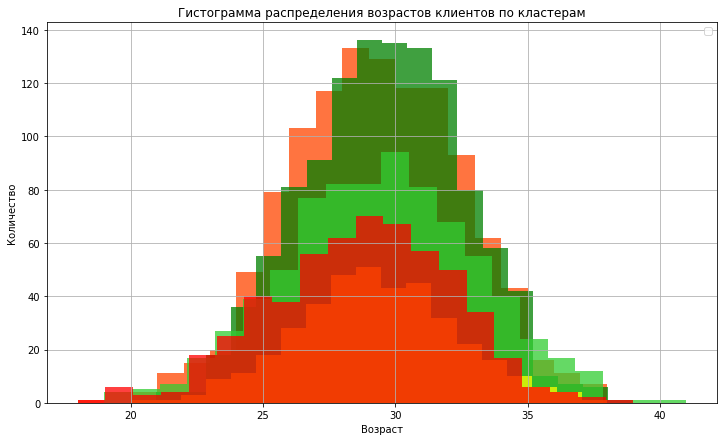

In [51]:
plt.figure(figsize=(12, 12))
for i in range(5):
    gym_churn[gym_churn['Сluster'] == i]['Age'].hist(bins=len(gym_churn[gym_churn['Сluster'] == i]['Age'].unique()), \
                                                 figsize=(12, 7), alpha=0.75, \
                                                 color=cluster_churn_rate[cluster_churn_rate['Сluster'] == i]['Color'])
plt.legend()
ax = plt.gca()
plt.grid(True)
ax.set_xlabel('Возраст')
ax.set_ylabel('Количество')
plt.title('Гистограмма распределения возрастов клиентов по кластерам');

**Вывод:** посетители более «надёжных» кластеров старше по возрасту.

No handles with labels found to put in legend.


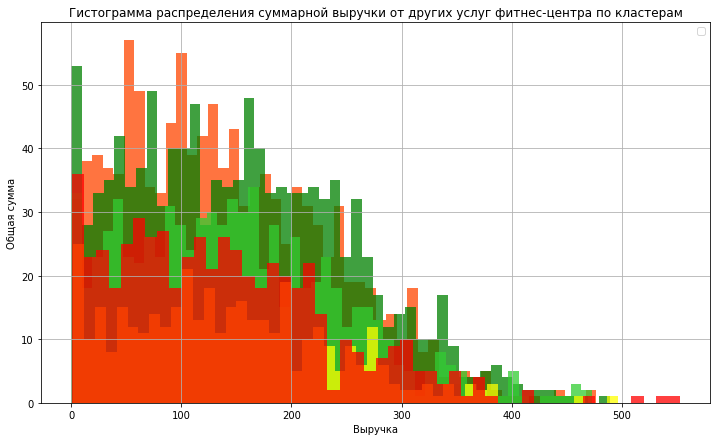

In [52]:
plt.figure(figsize=(12, 12))
for i in range(5):
    gym_churn[gym_churn['Сluster'] == i]['Avg_additional_charges_total'].\
    hist(bins=50, figsize=(12, 7), alpha=0.75, color=cluster_churn_rate[cluster_churn_rate['Сluster'] == i]['Color'])
plt.legend()
ax = plt.gca()
plt.grid(True)
ax.set_xlabel('Выручка')
ax.set_ylabel('Общая сумма')
plt.title('Гистограмма распределения cуммарной выручки от других услуг фитнес-центра по кластерам');

**Вывод:** посетители более «надёжных» кластеров чаще пользуются другими услугами фитнес-центра;

No handles with labels found to put in legend.


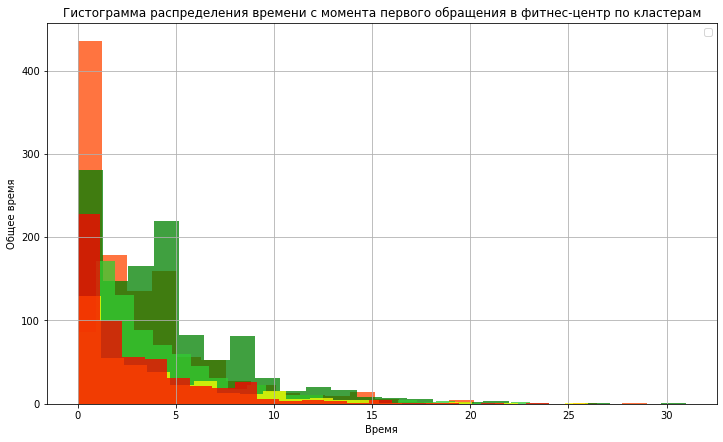

In [53]:
plt.figure(figsize=(12, 12))
for i in range(5):
    gym_churn[gym_churn['Сluster'] == i]['Lifetime'].\
    hist(bins=len(gym_churn[gym_churn['Сluster'] == i]['Lifetime'].unique()), \
         figsize=(12, 7), alpha=0.75, color=cluster_churn_rate[cluster_churn_rate['Сluster'] == i]['Color'])
plt.legend()
ax = plt.gca()
plt.grid(True)
ax.set_xlabel('Время')
ax.set_ylabel('Общее время')
plt.title('Гистограмма распределения времени с момента первого обращения в фитнес-центр по кластерам');

**Вывод:** посетители более «надёжных» кластеров раньше обратились в фитнес-центр.

No handles with labels found to put in legend.


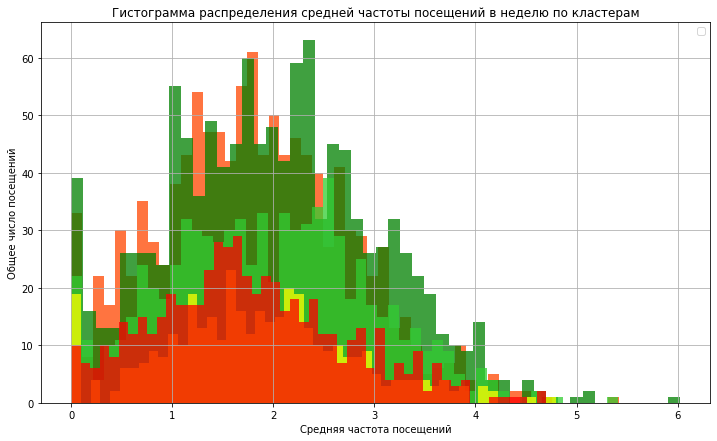

In [54]:
plt.figure(figsize=(12, 12))
for i in range(5):
    gym_churn[gym_churn['Сluster'] == i]['Avg_class_frequency_total'].\
    hist(bins=50, figsize=(12, 7), alpha=0.75, color=cluster_churn_rate[cluster_churn_rate['Сluster'] == i]['Color'])
plt.legend()
ax = plt.gca()
plt.grid(True)
ax.set_xlabel('Средняя частота посещений')
ax.set_ylabel('Общее число посещений')
plt.title('Гистограмма распределения средней частоты посещений в неделю по кластерам');

**Вывод:** посетители более «надёжных» кластеров чаще посещают фитнес-центр.

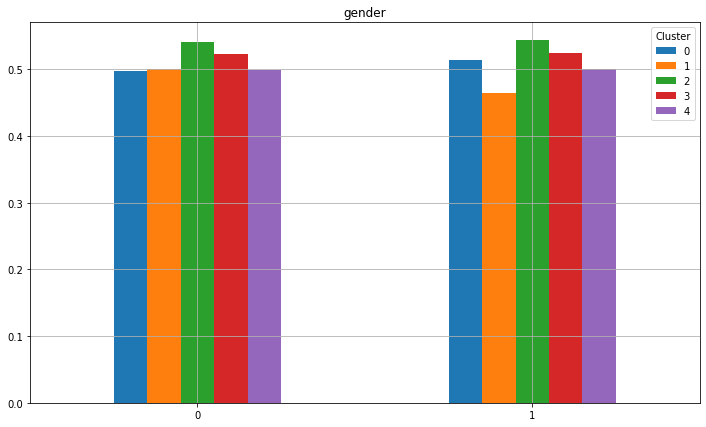

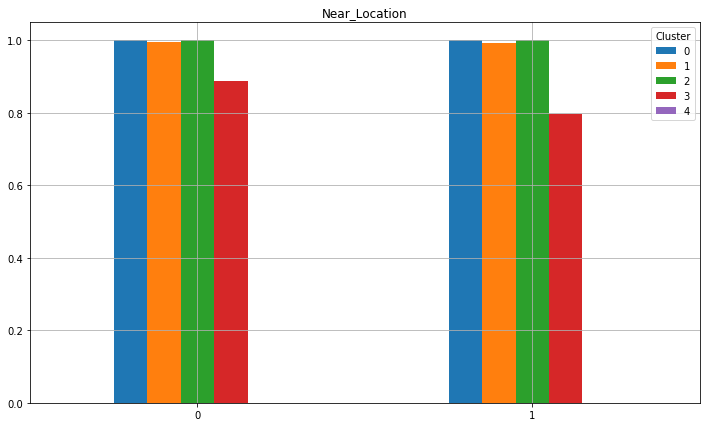

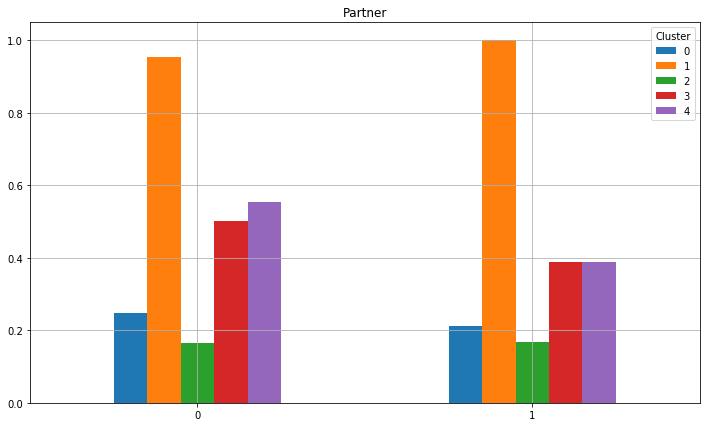

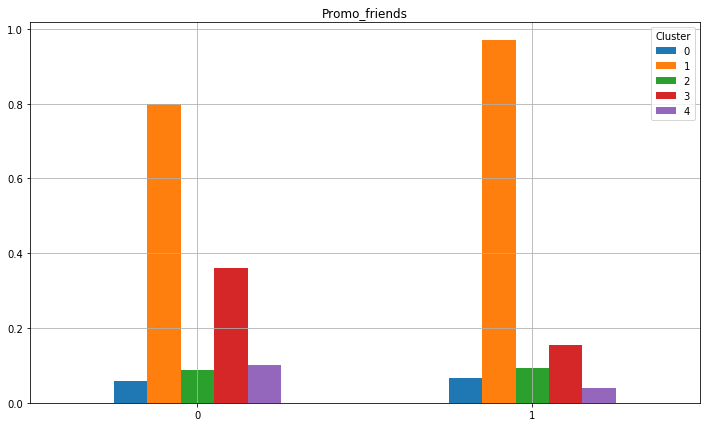

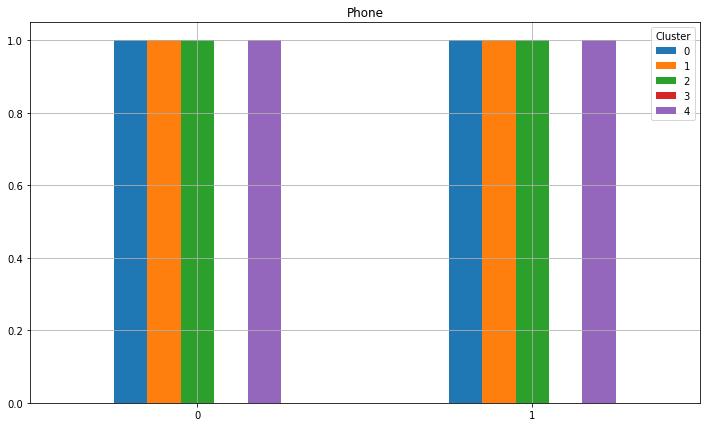

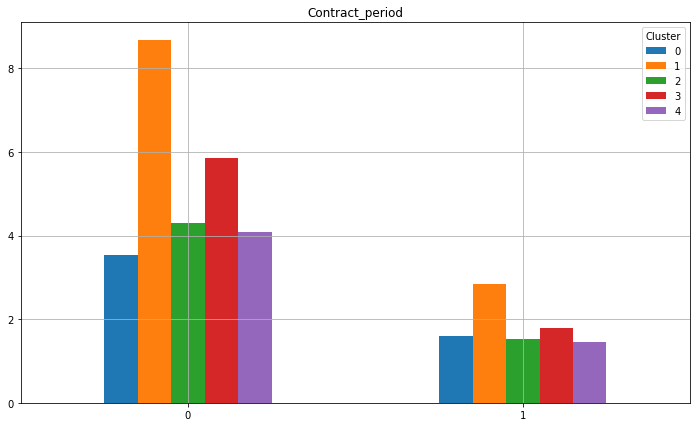

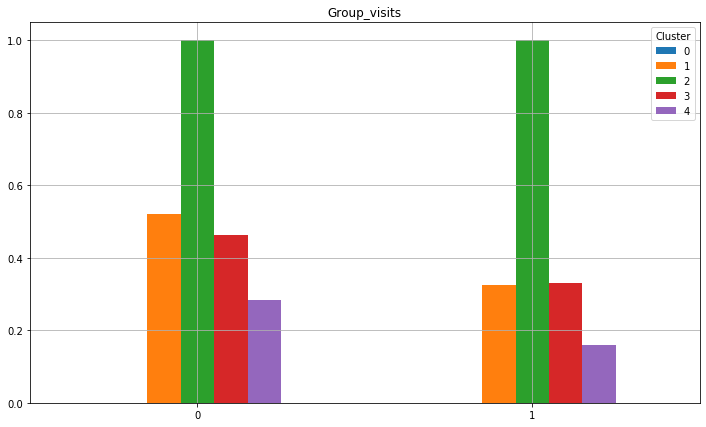

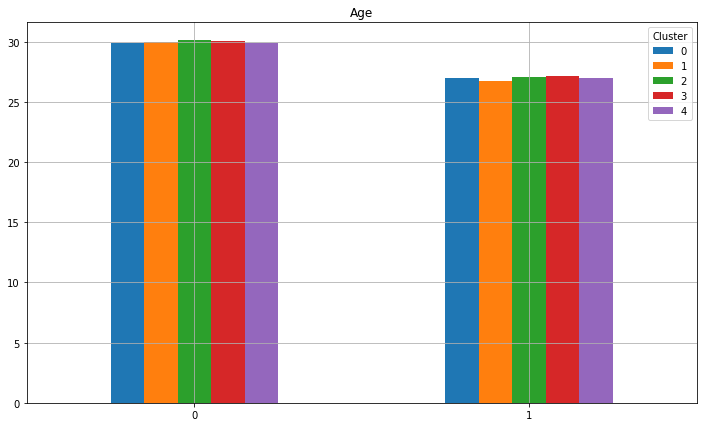

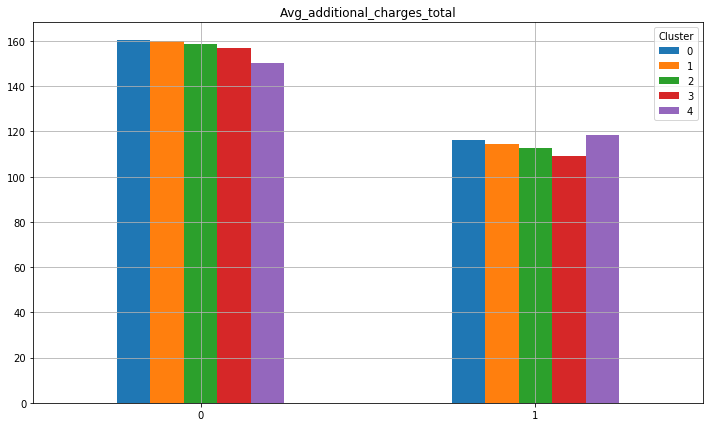

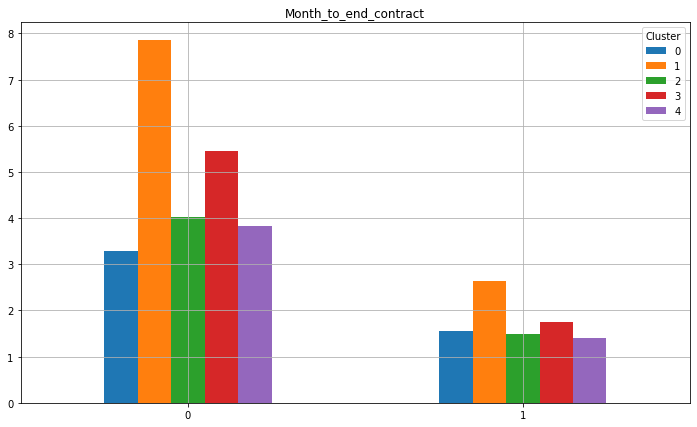

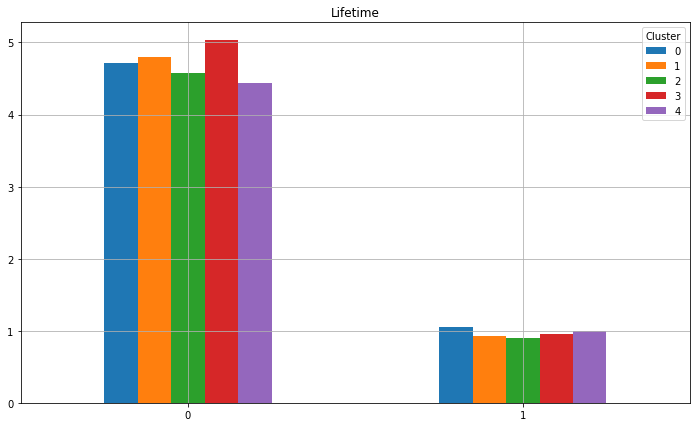

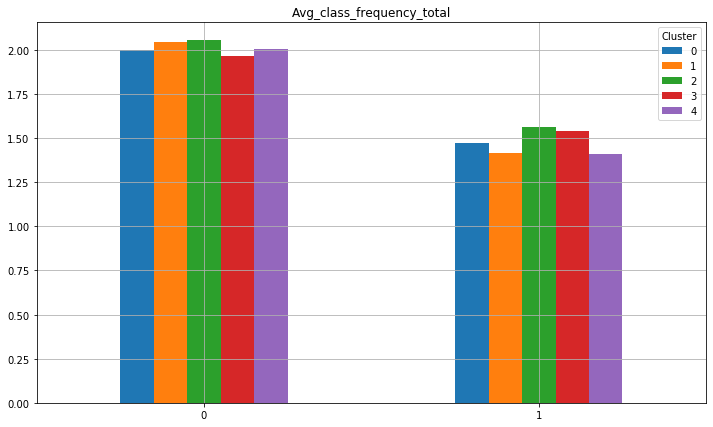

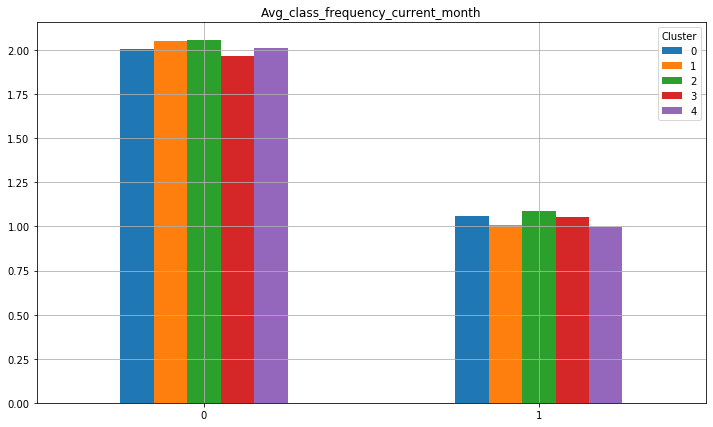

In [55]:
for i in gym_churn.columns[0:13]:
    pd.concat([gym_churn[gym_churn['Churn'] == 0].groupby('Сluster').agg({i: 'mean'}), \
               gym_churn[gym_churn['Churn'] == 1].groupby('Сluster').agg({i: 'mean'})], axis=1).T.\
    plot(kind='bar', figsize=(12, 7), grid=True, title=i)
    ax = plt.gca()
    ax.set_xticklabels([0, 1], rotation = 0);

Построим боксплоты для непрерывных признаков. Выводы прежние.

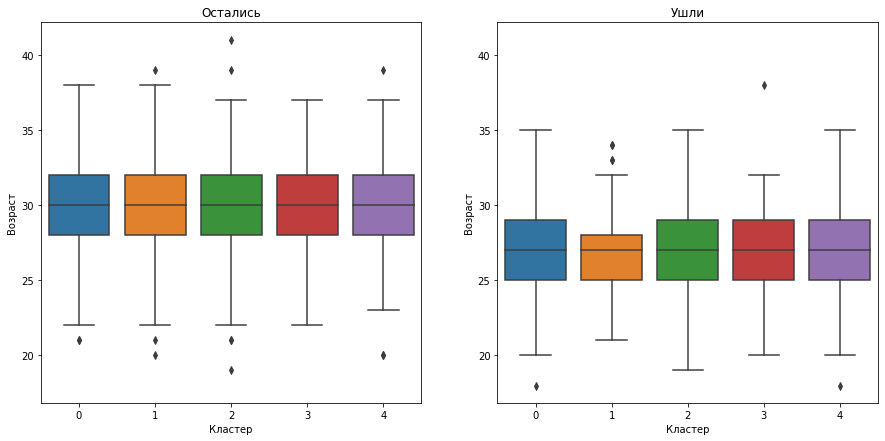

In [56]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.boxplot(x='Сluster', y='Age', data=gym_churn[gym_churn['Churn'] == 0])
ax = plt.gca()
ax.set_xlabel('Кластер')
ax.set_ylabel('Возраст')
plt.title('Остались');
plt.subplot(1, 2, 2, sharey=ax)
sns.boxplot(x='Сluster', y='Age', data=gym_churn[gym_churn['Churn'] == 1])
ax = plt.gca()
ax.set_xlabel('Кластер')
ax.set_ylabel('Возраст')
plt.title('Ушли');

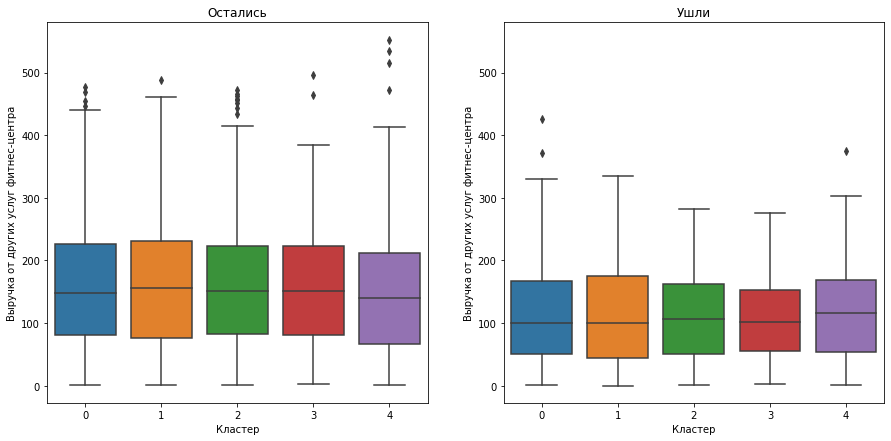

In [57]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.boxplot(x='Сluster', y='Avg_additional_charges_total', data=gym_churn[gym_churn['Churn'] == 0])
ax = plt.gca()
ax.set_xlabel('Кластер')
ax.set_ylabel('Выручка от других услуг фитнес-центра')
plt.title('Остались');
plt.subplot(1, 2, 2, sharey=ax)
sns.boxplot(x='Сluster', y='Avg_additional_charges_total', data=gym_churn[gym_churn['Churn'] == 1])
ax = plt.gca()
ax.set_xlabel('Кластер')
ax.set_ylabel('Выручка от других услуг фитнес-центра')
plt.title('Ушли');

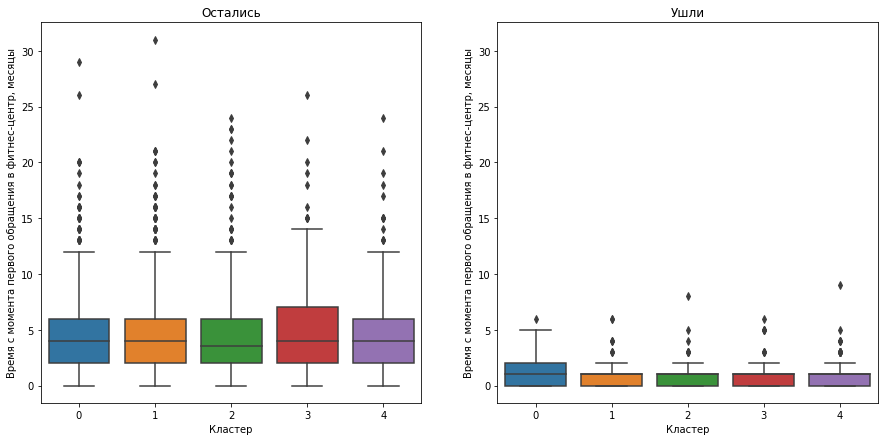

In [58]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.boxplot(x='Сluster', y='Lifetime', data=gym_churn[gym_churn['Churn'] == 0])
ax = plt.gca()
ax.set_xlabel('Кластер')
ax.set_ylabel('Время с момента первого обращения в фитнес-центр, месяцы')
plt.title('Остались');
plt.subplot(1, 2, 2, sharey=ax)
sns.boxplot(x='Сluster', y='Lifetime', data=gym_churn[gym_churn['Churn'] == 1])
ax = plt.gca()
ax.set_xlabel('Кластер')
ax.set_ylabel('Время с момента первого обращения в фитнес-центр, месяцы')
plt.title('Ушли');

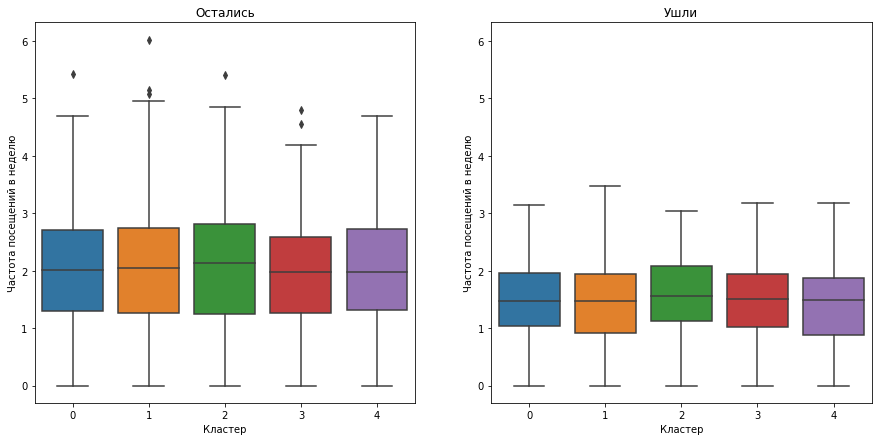

In [59]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.boxplot(x='Сluster', y='Avg_class_frequency_total', data=gym_churn[gym_churn['Churn'] == 0])
ax = plt.gca()
ax.set_xlabel('Кластер')
ax.set_ylabel('Частота посещений в неделю')
plt.title('Остались');
plt.subplot(1, 2, 2, sharey=ax)
sns.boxplot(x='Сluster', y='Avg_class_frequency_total', data=gym_churn[gym_churn['Churn'] == 1])
ax = plt.gca()
ax.set_xlabel('Кластер')
ax.set_ylabel('Частота посещений в неделю')
plt.title('Ушли');

### [К оглавлению](#contents)

## Шаг 5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами<a class="anchor" id="chapter5"></a>

1. Мотивировать молодых (младше 28-ми лет) и новичков (меньше 2-х месяцев). (Скидки на полугодовой абонемент по возрасту?) В тоже время ветераны (старше 30-ти лет) и старожилы (больше полугода) более мотивированы.
2. Стимулировать тех, кто посещает фитнес-центр 1,5 раза в неделю и меньше. СМС от тренера?
3. Развивать другие услуги фитнес-центра: кафе, спорт-товары, косметический и массажный салон.
4. Регулярно проводить групповые занятия, а также акции «приведи друга».

### Общие выводы

- пол мало влияет на отток;
- те, кто остался, чаще проживают или работают в районе, где находится фитнес-центр;
- сотрудники компаний-партнёров клуба чаще остаются;
- те, кто приходят от друзей, чаще остаются;
- наличие контактного телефона не влияет на отток;
- чем дольше длительность текущего действующего абонемента, тем выше вероятность остаться;
- посетители групповых занятий чаще остаются;
- посетители постарше чаще остаются;
- те, кто остался, чаще пользуются другими услугами фитнес-центра;
- чем дольше до окончания текущего действующего абонемента, тем чаще остаются;
- те, кто раньше обратились в фитнес-центр, чаще остаются;
- те, кто чаще посещают фитнес-центр (за всё время или за предыдущий месяц), чаще остаются.

### Среднестатистический клиент:

- может быть как мужчиной, так и женщиной;
- чаще всего проживает или работает в районе фитнес-центра;
- почти в половине случаев сотрудник компании-партнёра клуба;
- в 30% случаев записался по акции «приведи друга»;
- почти всегда есть контактный телефон;
- его абонемент от трёх месяцев до полугода;
- в 41% случаев посещает групповые занятия;
- ему около 29 лет;
- пользуется другими услугами фитнес-центра незначительно;
- до конца его абонемента от трёх месяцев до полугода;
- посещает фитнес-центр уже четыре месяца;
- посещает фитнес-центр меньше двух раз в неделю;
- последний месяц стал ходить немного реже.

Следующие признаки сильно коррелируют: `Contract_period` — длительность текущего действующего абонемента и `Month_to_end_contract` — срок до окончания текущего действующего абонемента, `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента и `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц.

Наиболее важными признаками оказались: время с момента первого обращения в фитнес-центр, длительность текущего действующего абонемента, возраст, средняя частота посещений в неделю и суммарная выручка от других услуг фитнес-центра.

Важность признаков, найденных алгоритмом *К средних*, отличается от модели логистической регрессии. Для *К средних* менее важны возраст, средняя частота посещений в неделю и суммарная выручка от других услуг фитнес-центра, зато он кластеризует по сотрудникам компаний-партнёров, акции «приведи друга», длительности действующего абонемента, посещению групповых занятий и времени с момента первого обращения в фитнес-центр.

### [К оглавлению](#contents)